In [227]:
import cmath
from datetime import datetime
import json
import os
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp

from qaoa_solver import QAOASolver
from utils import plot_quantum_state_probabilities, int_to_binary_str

warnings.simplefilter(action='ignore', category=FutureWarning)

In [228]:
def get_setup(experiment):
    return '_'.join(experiment.split('_')[2:])

In [ ]:
experiment_names = [e.removesuffix('_conf.json') for e in os.listdir('experiments') if e.endswith('_conf.json')]
experiment_configs = []
experiment_results = []

for experiment in experiment_names:
    try:
        with open(f'experiments/{experiment}_conf.json', 'r') as f:
            conf = json.load(f)
            conf['experiment'] = experiment
            conf['setup'] = get_setup(experiment)
            experiment_configs.append(conf)
        
        experiment_result_files = os.listdir(f'experiments/results/{experiment}')
        
        for result_file in experiment_result_files:
            result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S')
            result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
            result['experiment'] = experiment
            result['modification_date'] = result_date
            experiment_results.append(result)
    except:
        print(f'Error reading experiment {experiment}')

experiment_configs = pd.DataFrame(experiment_configs)

experiment_results = pd.concat(experiment_results)
experiment_results['num_2qub_gates'] = experiment_results['gate_sizes'].apply(lambda d: d['2'] + d.get('3',0)*2 + d.get('4',0)*4)
experiment_results['state_comp_probs'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['state_comp_max'] = experiment_results['state_comp_probs'].apply(lambda s: np.argmax(s))
experiment_results['state_comp_max_bin'] = experiment_results.apply(lambda row: int_to_binary_str(row['state_comp_max'], row['nx']+row['ny']), axis=1)

TypeError: 'NoneType' object is not callable

In [226]:
experiment_configs

,number,layers,problem_hamiltonian,cost_hamiltonian,mixer_hamiltonian,optimizer_opts,experiment,setup
0,33,5,simplified_problem_H,abs_cost_H,default_mixer_H,{'adaptive': True},N33_p5_Hp=simp_Hc=abs,Hp=simp_Hc=abs
1,33,3,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N33_p3_default,default
2,35,1,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N35_p1_default,default
3,39,2,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N39_p2_default,default
4,15,6,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N15_p6_default,default
...,...,...,...,...,...,...,...,...
79,21,1,simplified_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N21_p1_Hp=simp,Hp=simp
80,21,1,simplified_problem_H,abs_cost_H,default_mixer_H,{'adaptive': True},N21_p1_Hp=simp_Hc=abs,Hp=simp_Hc=abs
81,21,1,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N21_p1_default,default
82,33,5,default_problem_H,default_cost_H,default_mixer_H,{'adaptive': True},N33_p5_default,default


In [225]:
experiment_results.columns

Index(['N', 'nx', 'ny', 'layers', 'num_gates', 'gate_sizes', 'device',
       'gammas_0', 'betas_0', 'gammas', 'betas', 'cost', 'steps', 'fidelity',
       'state', 'success', 'message', 'rep', 'experiment', 'modification_date',
       'num_2qub_gates', 'state_comp_probs', 'state_comp_max',
       'state_comp_max_bin'],
      dtype='object')

In [208]:
experiment_results_agg = (
    experiment_results
        .groupby('experiment')
        .agg({
            'rep': 'count',
            'steps': ['mean', 'median', 'std', 'max', 'min'],
            'num_gates': ['mean', 'median', 'std', 'max', 'min'],
            'num_2qub_gates': ['mean', 'median', 'std', 'max', 'min'],
            'cost': ['mean', 'median', 'std'], 
            'fidelity': ['mean', 'median', 'std', 'max', 'min']
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]

experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

In [ ]:
df_details = pd.merge(experiment_configs, experiment_results, how='inner', on='experiment')
df_details = df_details.drop(columns='layers_y')
df_details = df_details.rename(columns={'layers_x': 'layers'})

experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

if (experiments_df['num_gates_std'] != 0).any():
    print('Warning: There are experiments with inconsistent number of gates')

# N = 15

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $15 = 3 \times 5$
* Factor simplification: $3 \rightarrow 1,\ 5 \rightarrow 2$
* Binary factors: $1 \rightarrow 1,\ 2 \rightarrow 10$
* Solution: $\ket{101}$

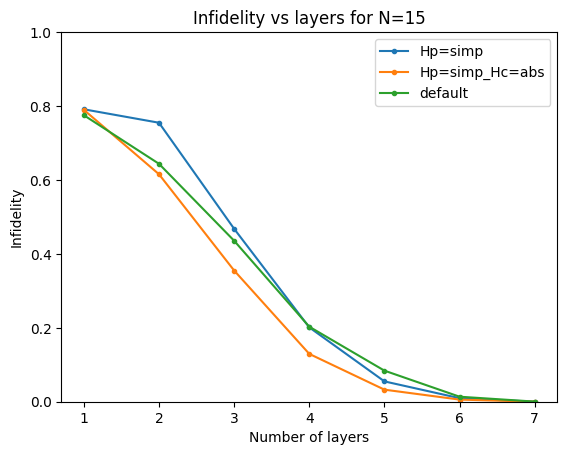

In [74]:
N = 15

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_median', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

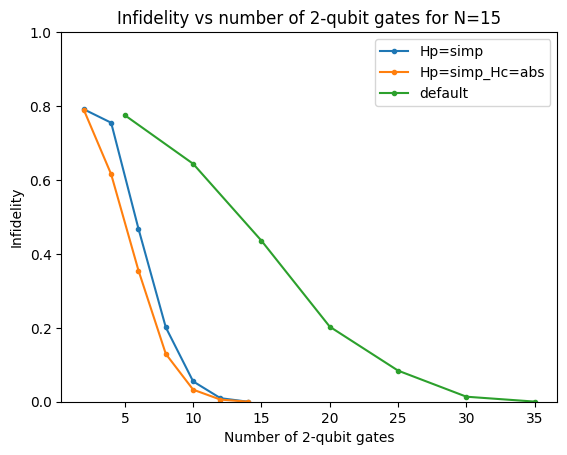

In [75]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

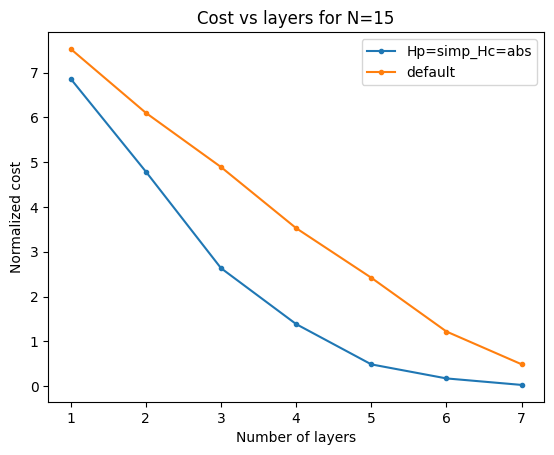

In [76]:
setups.remove('Hp=simp')

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.9891179258654582


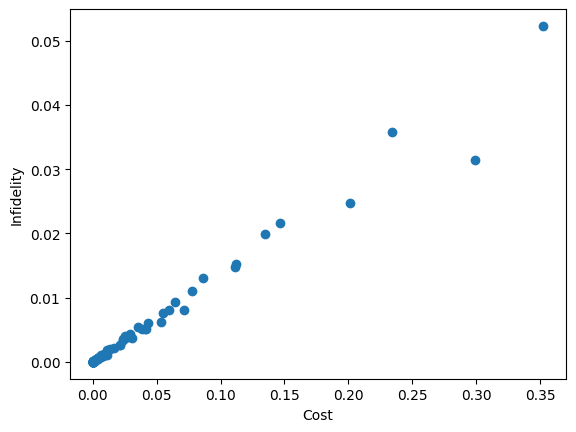

In [77]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

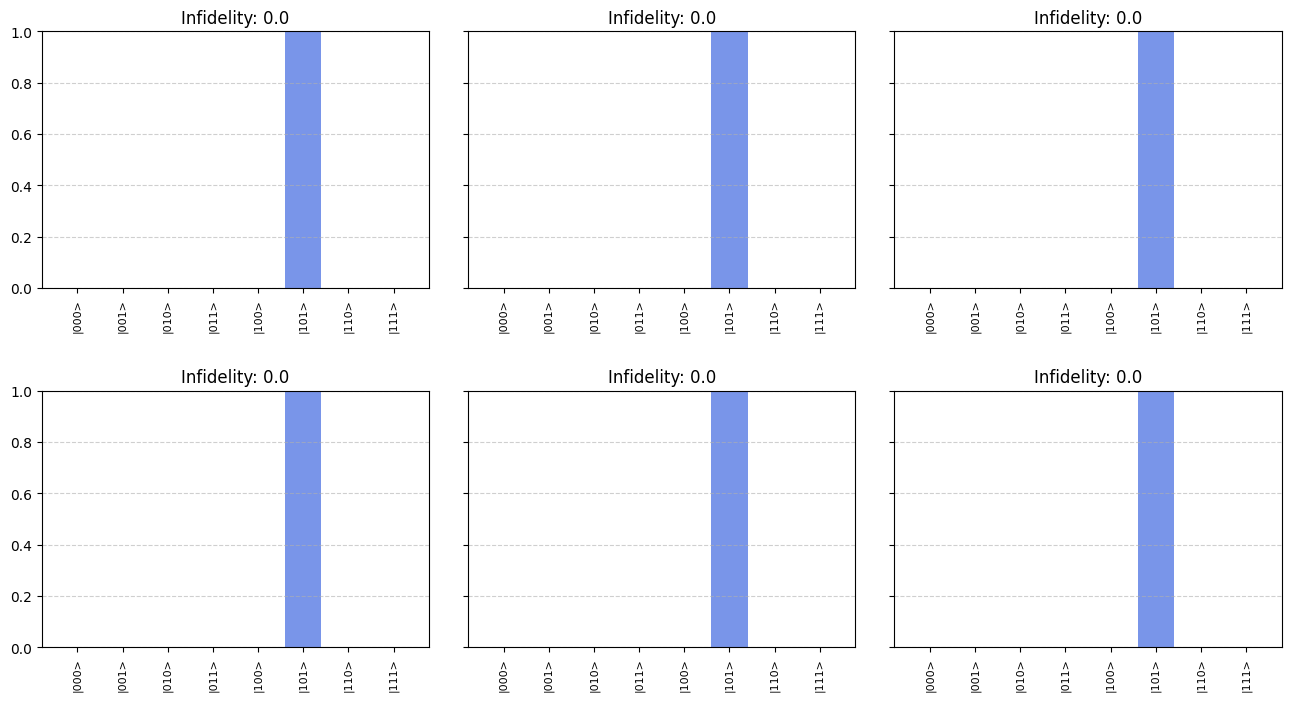

In [154]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for i, row in df_det.sort_values('infidelity').head(6).reset_index().iterrows():
    plot_quantum_state_probabilities(row.state, axs.flatten()[i], f'Infidelity: {round(row.infidelity, 2)}')

# N = 21

* Required qubits: $n_x = 1,\ n_y = 2$
* Factorization: $21 = 3 \times 7$
* Factor simplification: $3 \rightarrow 1,\ 7 \rightarrow 3$
* Binary factors: $1 \rightarrow 1,\ 3 \rightarrow 11$
* Solution: $\ket{111}$

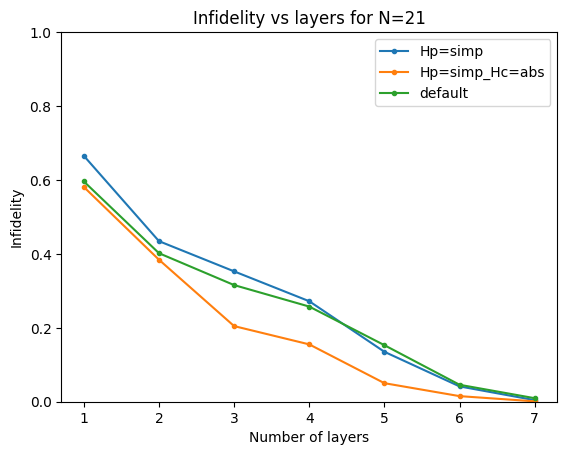

In [155]:
N = 21

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique().tolist()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

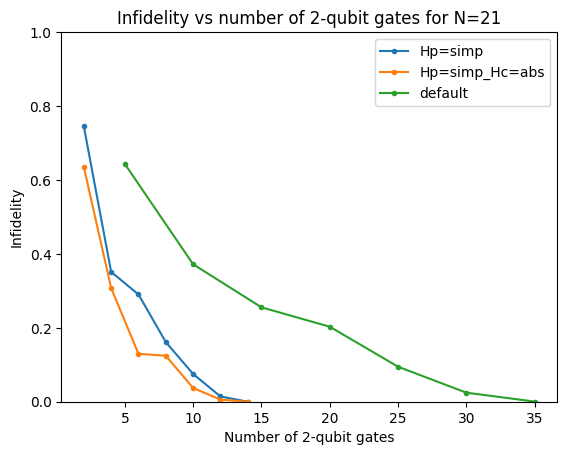

In [156]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

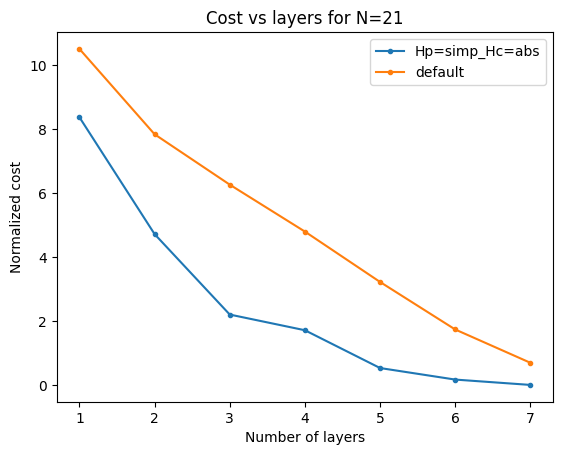

In [157]:
setups.remove('Hp=simp')

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.9756647746967945


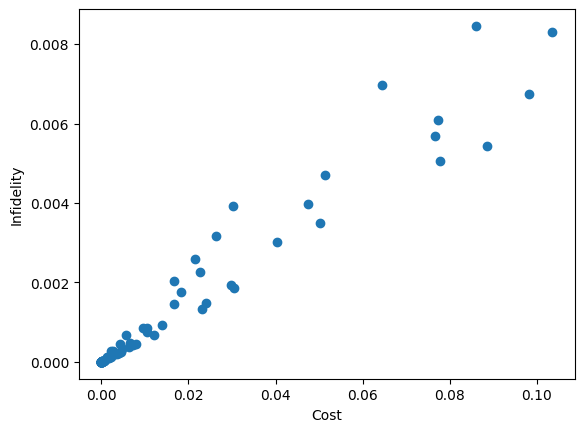

In [158]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

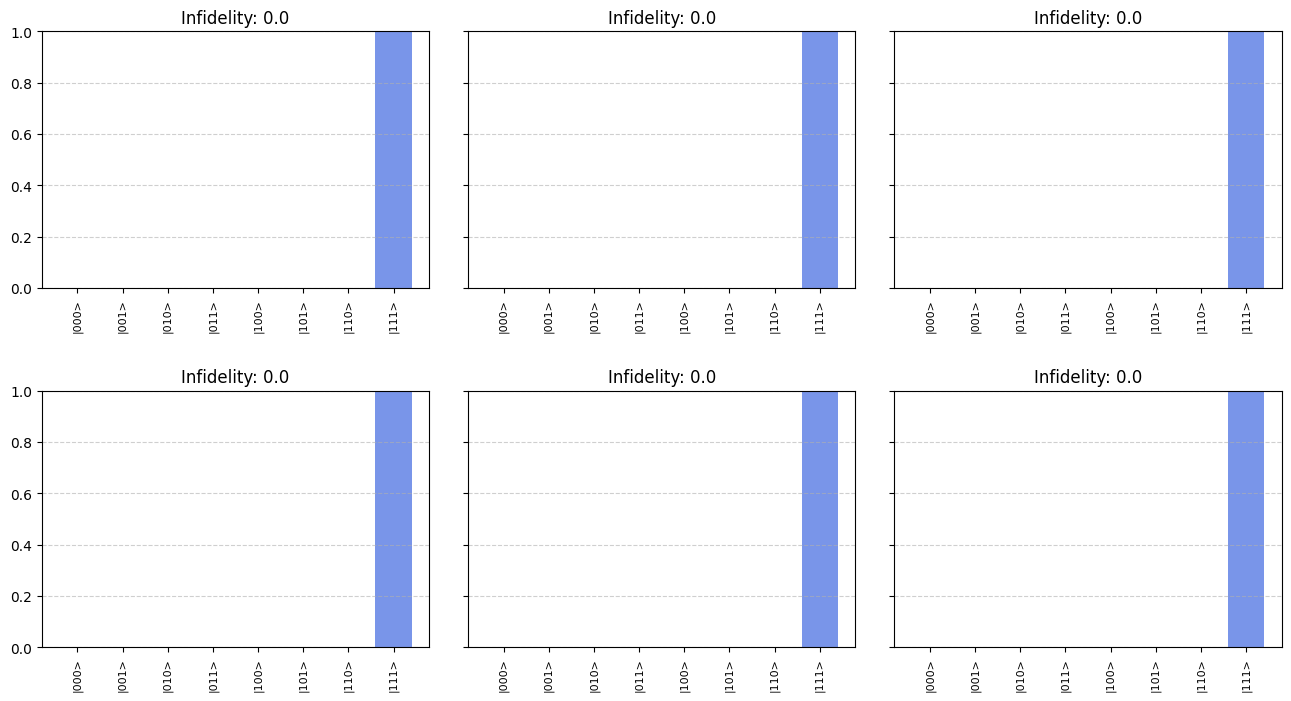

In [159]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for i, row in df_det.sort_values('infidelity').head(6).reset_index().iterrows():
    plot_quantum_state_probabilities(row.state, axs.flatten()[i], f'Infidelity: {round(row.infidelity, 2)}')

# N = 33

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $33 = 3 \times 11$
* Factor simplification: $3 \rightarrow 1,\ 11 \rightarrow 5$
* Binary factors: $1 \rightarrow 1,\ 5 \rightarrow 101$
* Solution: $\ket{10101}$

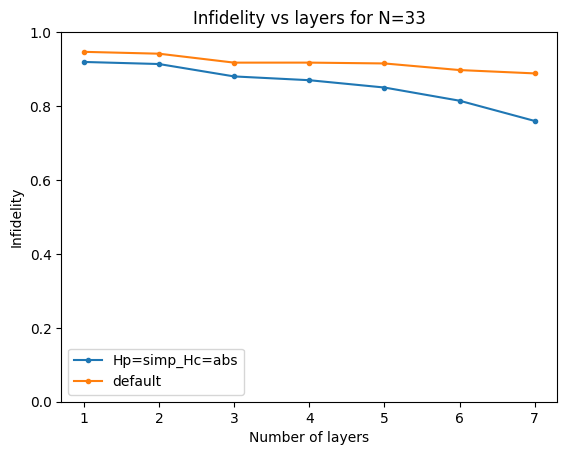

In [160]:
N = 33

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

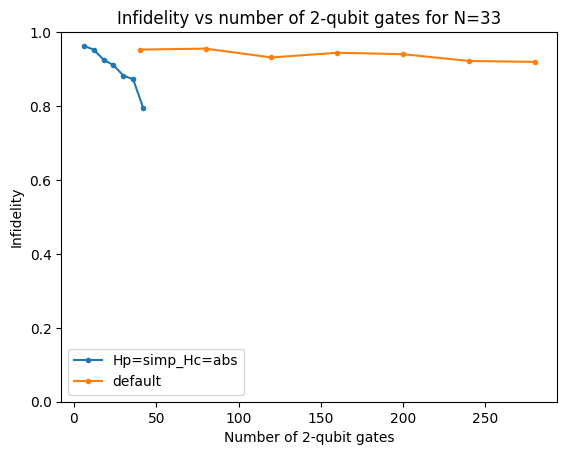

In [161]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

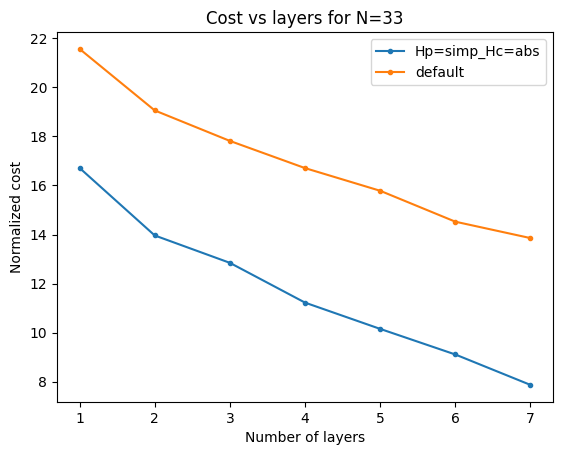

In [162]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.43435472385508483


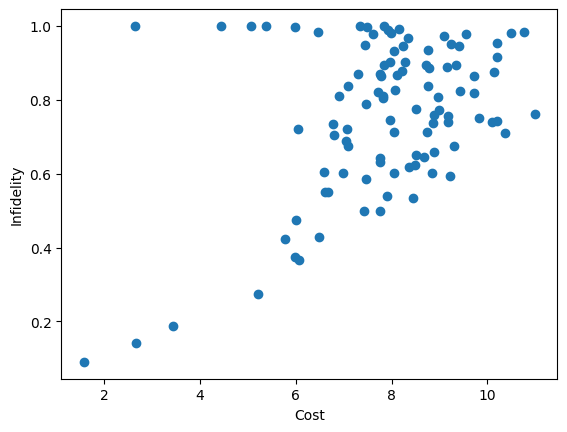

In [163]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

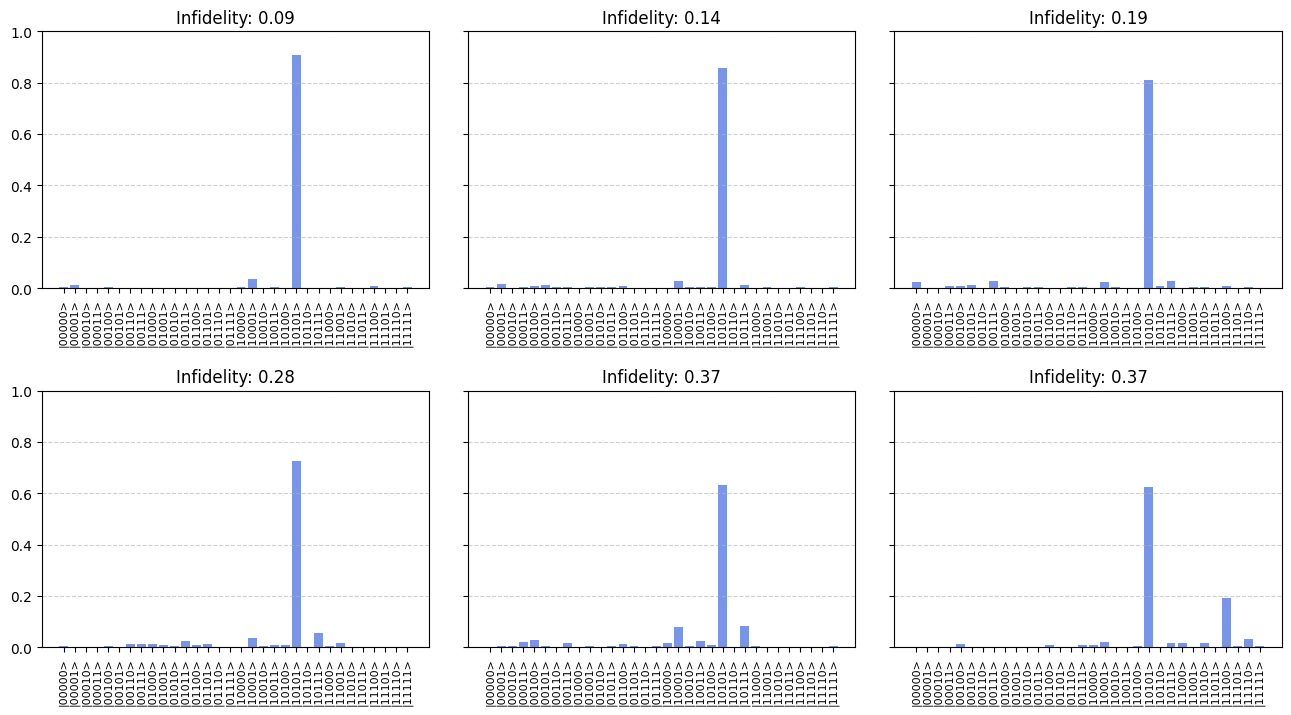

In [164]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for i, row in df_det.sort_values('infidelity').head(6).reset_index().iterrows():
    plot_quantum_state_probabilities(row.state, axs.flatten()[i], f'Infidelity: {round(row.infidelity, 2)}')

# N = 35

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $35 = 5 \times 7$
* Factor simplification: $5 \rightarrow 2,\ 7 \rightarrow 3$
* Binary factors: $2 \rightarrow 10,\ 3 \rightarrow 11$
* Solutions: $\ket{01110}$ and $\ket{11010}$

Degeneracy: solutions 10 and 11 can be exchanged and fit in both $n_x$ and $n_y$ qubits

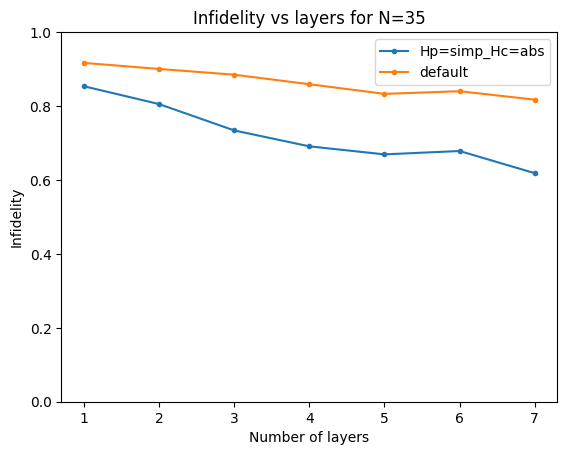

In [170]:
N = 35

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

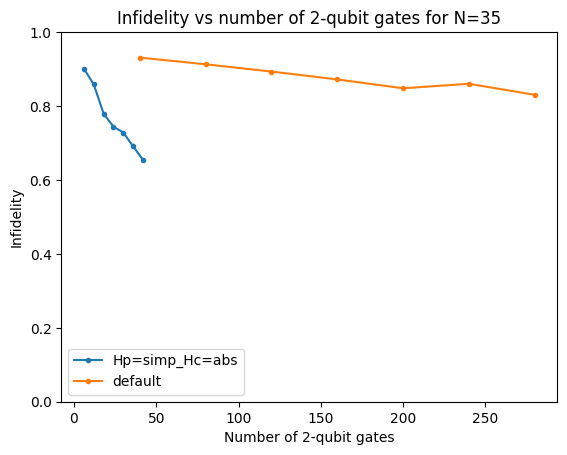

In [171]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

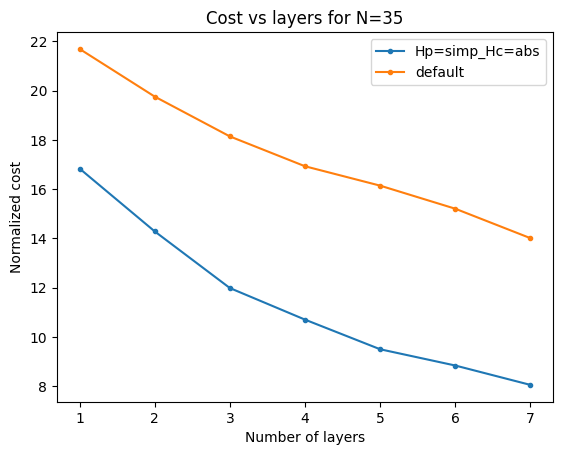

In [172]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.7432280394765282


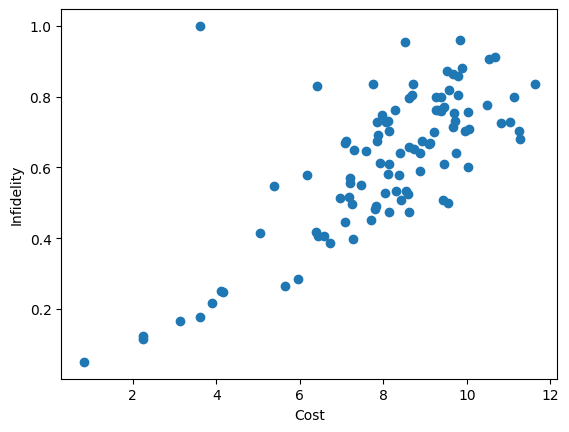

In [173]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

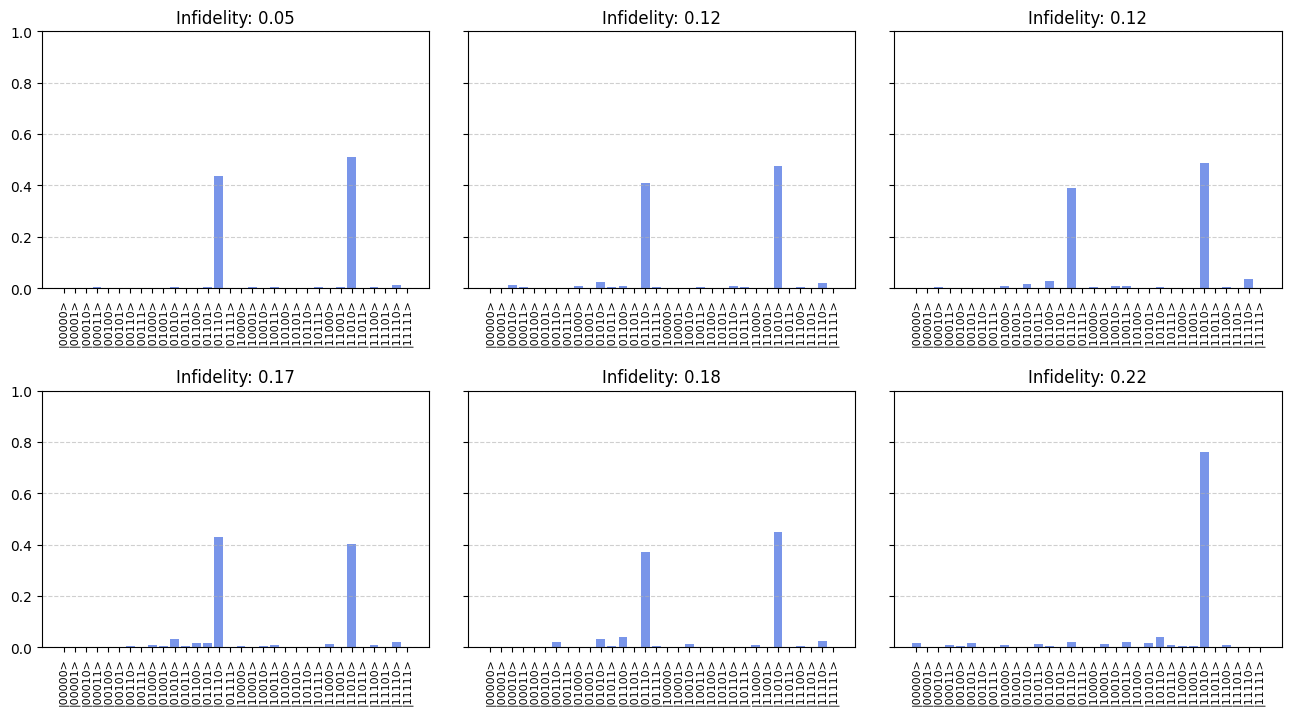

In [174]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for i, row in df_det.sort_values('infidelity').head(6).reset_index().iterrows():
    plot_quantum_state_probabilities(row.state, axs.flatten()[i], f'Infidelity: {round(row.infidelity, 2)}')

# N = 39

* Required qubits: $n_x = 2,\ n_y = 3$
* Factorization: $39 = 3 \times 13$
* Factor simplification: $3 \rightarrow 1,\ 13 \rightarrow 6$
* Binary factors: $3 \rightarrow 01,\ 6 \rightarrow 110$
* Solution: $\ket{10011}$

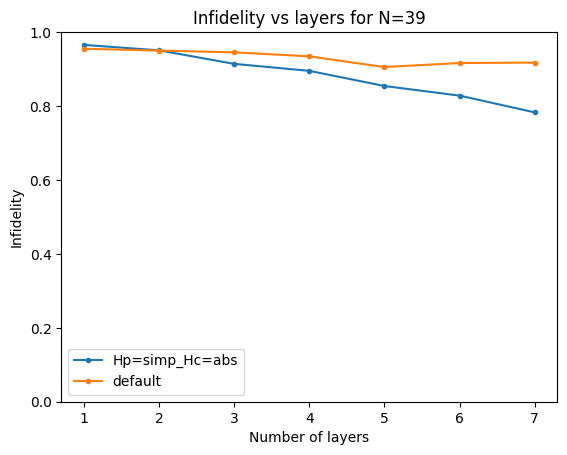

In [175]:
N = 39

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers'])

setups = df['setup'].unique()
layers = df['layers'].unique()

for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('layers', 'infidelity_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Infidelity vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

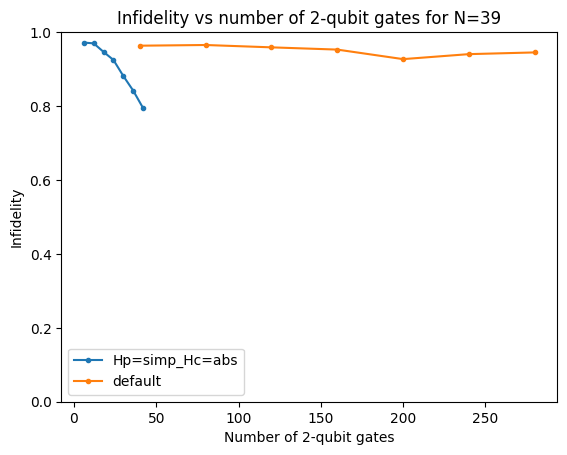

In [176]:
for setup in setups:
    df_s = df[df['setup']==setup]
    plt.plot('num_2qub_gates_max', 'infidelity_median', data=df_s, marker='.')

plt.title(f'Infidelity vs number of 2-qubit gates for N={N}')
plt.xlabel('Number of 2-qubit gates')
plt.ylabel('Infidelity')
plt.ylim(0,1)
plt.legend(setups);

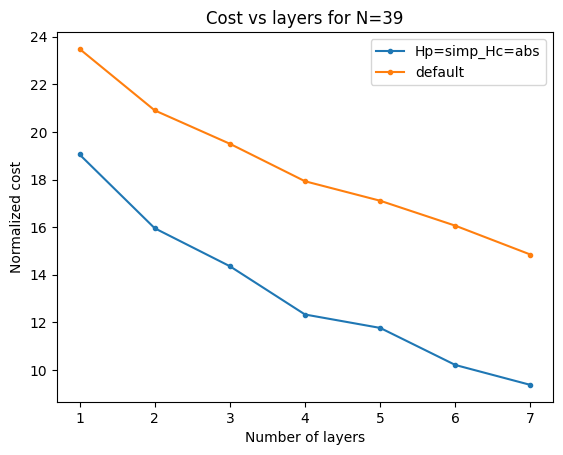

In [177]:
for setup in setups:
    df_s = df[df['setup']==setup].copy()
    if setup == 'default':
        df_s['cost_mean'] = np.sqrt(df_s['cost_mean'])
    plt.plot('layers', 'cost_mean', data=df_s, marker='.')
    plt.xticks(ticks=layers)

plt.title(f'Cost vs layers for N={N}')
plt.xlabel('Number of layers')
plt.ylabel('Normalized cost')
plt.legend(setups);

Correlation: 0.569116465594675


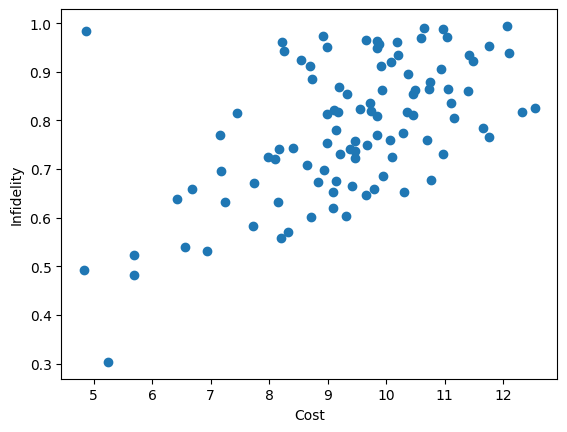

In [178]:
df_det = df_details[(df_details['N']==N) & (df_details['setup']=='Hp=simp_Hc=abs') & (df_details['layers']==7)].copy()
df_det['infidelity'] = 1 - df_det['fidelity']

plt.scatter('cost', 'infidelity', data=df_det);
plt.xlabel('Cost');
plt.ylabel('Infidelity');

print('Correlation:', df_det['infidelity'].corr(df_det['cost']))

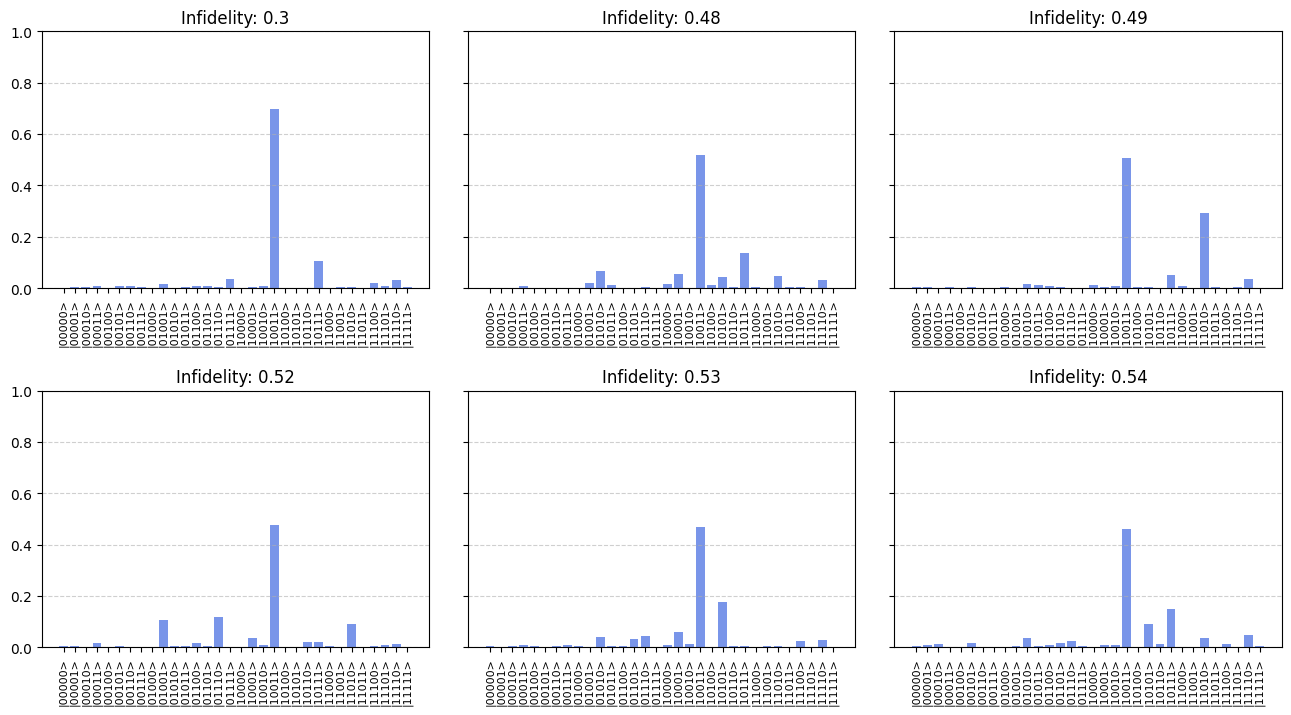

In [179]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
fig.subplots_adjust(wspace=0.1, hspace=0.4)

for i, row in df_det.sort_values('infidelity').head(6).reset_index().iterrows():
    plot_quantum_state_probabilities(row.state, axs.flatten()[i], f'Infidelity: {round(row.infidelity, 2)}')